In [50]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


warnings.filterwarnings("ignore")

In [51]:
data = pd.read_csv('clean-data.csv',sep=',')
data.head()

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,0,10.53,Crackers,7500,Prestasi Utama,Prestasi,General Trade
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,1,0.18,Crackers,7500,Prestasi Utama,Prestasi,General Trade
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,0,4.36,Crackers,7500,Prestasi Utama,Prestasi,General Trade
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,1,4.74,Crackers,7500,Prestasi Utama,Prestasi,General Trade
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,0,9.94,Crackers,7500,Prestasi Utama,Prestasi,General Trade


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transactionid   5020 non-null   object 
 1   customerid      5020 non-null   int64  
 2   date            5020 non-null   object 
 3   productid       5020 non-null   object 
 4   price_cust      5020 non-null   int64  
 5   qty             5020 non-null   int64  
 6   totalamount     5020 non-null   int64  
 7   storeid         5020 non-null   int64  
 8   age             5020 non-null   int64  
 9   gender          5020 non-null   int64  
 10  marital_status  5020 non-null   int64  
 11  income          5020 non-null   float64
 12  product_name    5020 non-null   object 
 13  price_prod      5020 non-null   int64  
 14  storename       5020 non-null   object 
 15  groupstore      5020 non-null   object 
 16  type            5020 non-null   object 
dtypes: float64(1), int64(9), object(7

In [53]:
df_ts = data.groupby('date')['qty'].sum().reset_index()
df_ts.tail()

,date,qty
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44
364,2022-12-31,37


In [54]:
print(df_ts.shape)

(365, 2)


In [55]:
df_ts.describe()

,qty
count,365.000000
mean,50.126027
std,16.704461
min,15.000000
25%,38.000000
50%,49.000000
75%,59.000000
max,119.000000


In [56]:
df_ts.isnull().sum()

date    0
qty     0
dtype: int64

In [57]:
df_ts.isna().values.any()

False

In [58]:
df_ts[df_ts.duplicated()]

,date,qty


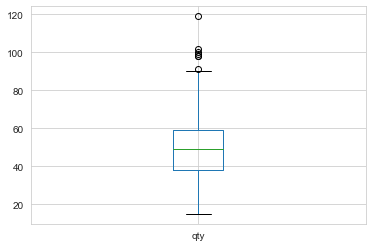

In [59]:
df_ts.boxplot()
plt.show()

In [60]:
Q1 = df_ts["qty"].quantile(0.25)
Q3 = df_ts["qty"].quantile(0.75)
IQR = Q3 - Q1
df_ts_clean = df_ts[
    ~((df_ts["qty"] < (Q1 - 1.5 * IQR)) | (df_ts["qty"] > (Q3 + 1.5 * IQR)))
]

In [61]:
df_ts_clean.tail()

,date,qty
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44
364,2022-12-31,37


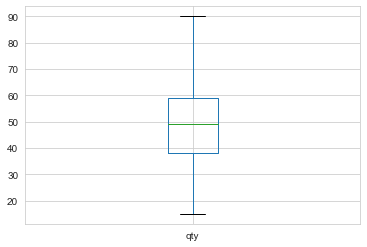

In [62]:
df_ts_clean.boxplot()
plt.show()

In [63]:
df_ts_clean["date"] = pd.to_datetime(df_ts_clean["date"], dayfirst=True)
df_ts_clean["qty"] = df_ts_clean["qty"].map(float)
df_ts_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    358 non-null    datetime64[ns]
 1   qty     358 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.4 KB


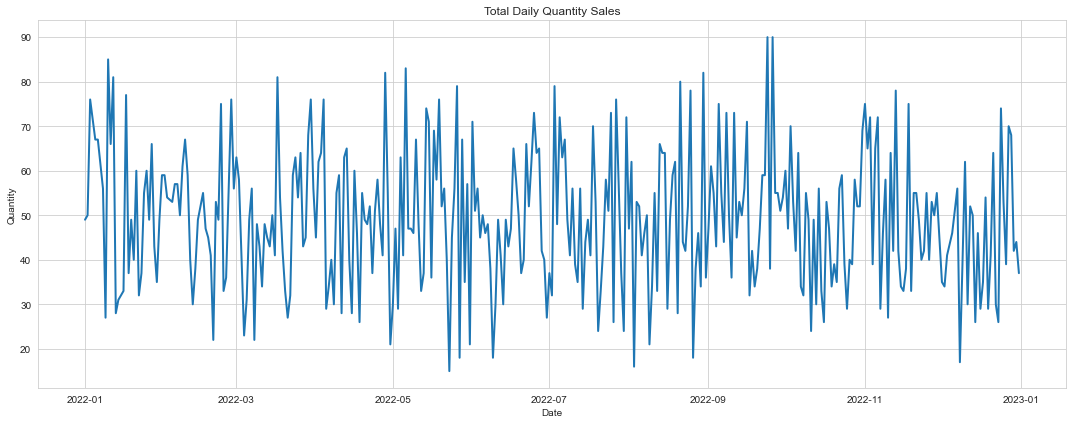

In [64]:
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")
sns.lineplot(data=df_ts_clean, x="date", y="qty", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Total Daily Quantity Sales")
plt.tight_layout()
plt.show()

In [65]:
df_ts_new = df_ts_clean.copy()
df_ts_new.set_index(df_ts_clean["date"], inplace=True)
df_ts_new.drop(columns=["date"], inplace=True)
df_ts_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 358 entries, 2022-01-01 to 2022-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   qty     358 non-null    float64
dtypes: float64(1)
memory usage: 5.6 KB


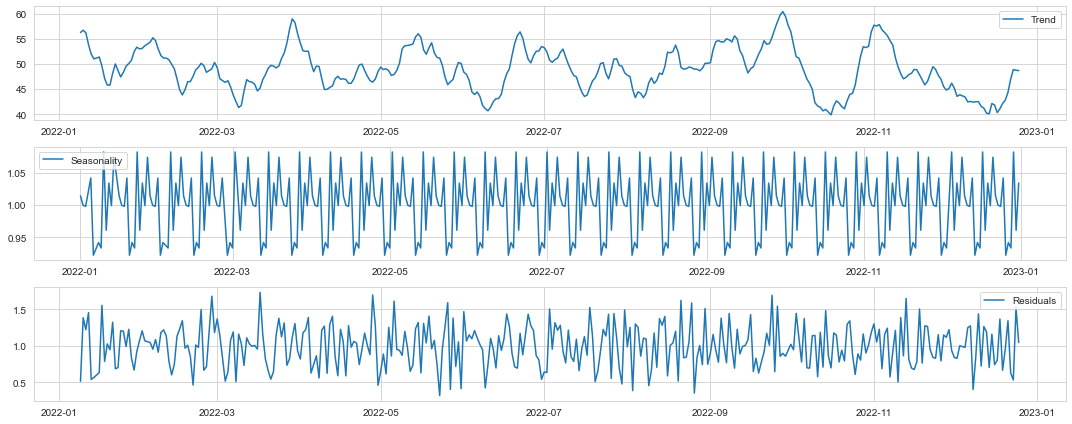

In [66]:
decomposition = seasonal_decompose(df_ts_new["qty"], model="multiplicative", period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(15, 6))
plt.subplot(311)
plt.plot(trend, label="Trend")
plt.legend(loc="best")
plt.subplot(312)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")
plt.subplot(313)
plt.plot(residual, label="Residuals")
plt.legend(loc="best")
plt.tight_layout()

In [67]:
roll_mean = df_ts_new.rolling(window=12).mean()
roll_std = df_ts_new.rolling(window=12).std()
print(roll_mean.head(5))
print(roll_std.head(5))

            qty
date           
2022-01-01  NaN
2022-01-02  NaN
2022-01-03  NaN
2022-01-05  NaN
2022-01-06  NaN
            qty
date           
2022-01-01  NaN
2022-01-02  NaN
2022-01-03  NaN
2022-01-05  NaN
2022-01-06  NaN


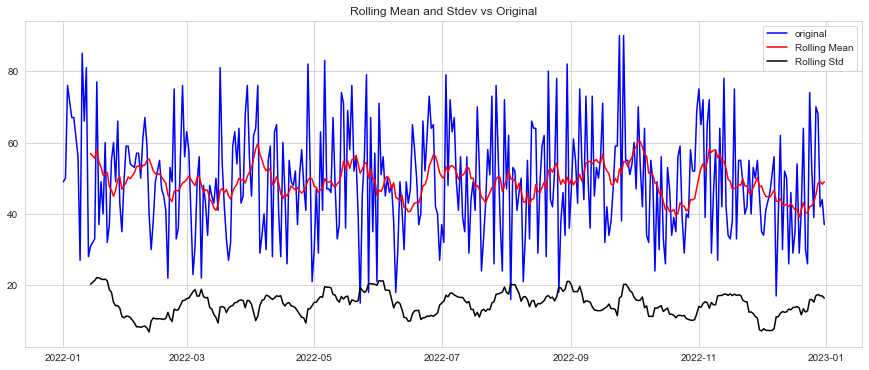

In [68]:
plt.figure(figsize=(15, 6))
plt.plot(df_ts_new["qty"], color="blue", label="original")
plt.plot(roll_mean, color="red", label="Rolling Mean")
plt.plot(roll_std, color="black", label="Rolling Std")
plt.title("Rolling Mean and Stdev vs Original")
plt.legend()

In [69]:
df_ts_new.head()

,qty
date,
2022-01-01,49.0
2022-01-02,50.0
2022-01-03,76.0
2022-01-05,67.0
2022-01-06,67.0


In [70]:
df_ts_diff = df_ts_new.copy()
adftest = adfuller(df_ts_diff["qty"])
adftest = adfuller(df_ts_diff)
adf_output = pd.Series(adftest[0:2], index=["Test Statistic", "p-value"])
print(adf_output)

Test Statistic   -18.980821
p-value            0.000000
dtype: float64


In [71]:
kpsstest = kpss(df_ts_diff["qty"])
kpss_output = pd.Series(kpsstest[0:2], index=["Test Statistic", "p-value"])
print(kpss_output)

Test Statistic    0.140039
p-value           0.100000
dtype: float64


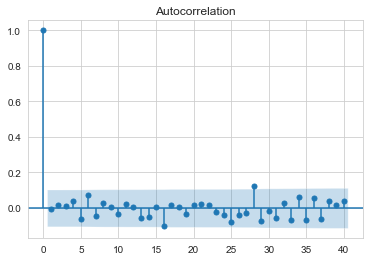

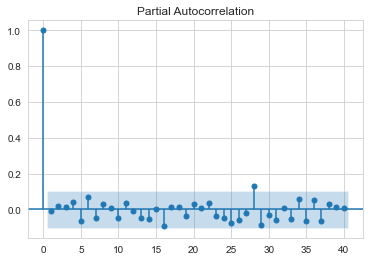

In [72]:
acf_original = plot_acf(df_ts_diff, lags=40)
pacf_original = plot_pacf(df_ts_diff, lags=40)

In [73]:
train_size = round(df_ts_diff.shape[0] * 0.987)
print(train_size)

353


In [74]:
train = df_ts_diff[:train_size]
test = df_ts_diff[train_size:]
print(train.shape)
print(test.shape)

(353, 1)
(5, 1)


In [84]:
arima_order = (5, 0, 5)
arima = ARIMA(train["qty"], order=arima_order)
arima_fit = arima.fit()
print(arima_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    qty   No. Observations:                  353
Model:                     ARMA(5, 5)   Log Likelihood               -1453.592
Method:                       css-mle   S.D. of innovations             14.671
Date:                Sat, 29 Jul 2023   AIC                           2931.185
Time:                        03:39:47   BIC                           2977.583
Sample:                             0   HQIC                          2949.647
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.1820      0.177    278.535      0.000      48.836      49.528
ar.L1.qty     -0.1023      0.037     -2.730      0.006      -0.176      -0.029
ar.L2.qty      0.3591      0.039      9.272      0.0

In [85]:
pred = arima_fit.predict()
df_train = pd.DataFrame(pred, columns=["prediksi"])
df_train["actual"] = train.values
df_train.head()

,prediksi,actual
date,,
2022-01-01,49.181989,49.0
2022-01-02,49.180825,50.0
2022-01-03,49.186390,76.0
2022-01-05,49.370203,67.0
2022-01-06,49.387483,67.0


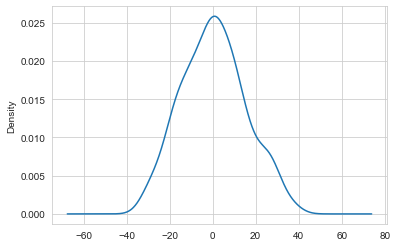

In [86]:
residual = df_train["actual"] - df_train["prediksi"]
residual.plot(kind="kde")
plt.show()


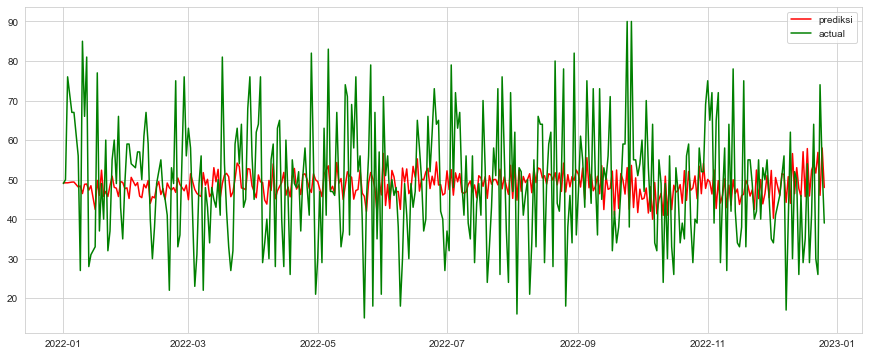

In [87]:
plt.figure(figsize=(15, 6))
plt.plot(df_train["prediksi"], color="red", label="prediksi")
plt.plot(df_train["actual"], color="green", label="actual")
plt.legend()
plt.show()

In [88]:
y_pred = arima_fit.forecast(len(test))[0]
df_test = pd.DataFrame(y_pred, columns=["prediksi"], index=test.index)
df_test["actual"] = test.values
df_test.head()

,prediksi,actual
date,,
2022-12-27,58.315643,70.0
2022-12-28,54.546132,68.0
2022-12-29,47.703664,42.0
2022-12-30,55.582994,44.0
2022-12-31,37.824114,37.0


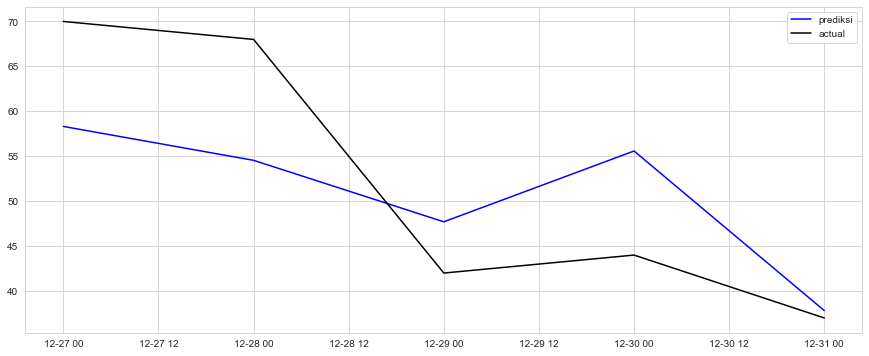

In [89]:
plt.figure(figsize=(15, 6))
plt.plot(df_test["prediksi"], color="blue", label="prediksi")
plt.plot(df_test["actual"], color="black", label="actual")
plt.legend()
plt.show()

In [90]:
rmse = mean_squared_error(df_test["actual"], df_test["prediksi"], squared=False)
mape = mean_absolute_percentage_error(df_test["actual"], df_test["prediksi"])
print(f"Nilai dari RMSE adalah sebesar {rmse:.3f}")
print(f"Nilai dari MAPE adalah sebesar {mape * 100:.3f} %")

Nilai dari RMSE adalah sebesar 9.848
Nilai dari MAPE adalah sebesar 15.722 %


In [82]:
forecast = arima_fit.forecast(3)[0]
forecast = pd.DataFrame(forecast, columns=["Prediction"])
forecast.head()

,Prediction
0,55.396961
1,53.733407
2,78.230135
